# Player Similarity Scores

Following up from **Predicting Map Difficulty with Score & Collaborative Filtering**, we now try to calculate similarity scores for all players

In [1]:
import warnings

import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import QuantileTransformer

from opal.conf.mods import OsuMod

# A false positive set by slice warning is shown, silence it
warnings.filterwarnings('ignore')
MAX_SCORE = 1e6

import pandas as pd

from opal.conf.conf import SCORES_DIR

df_full = pd.read_csv(SCORES_DIR / "top1k/raw.csv")

# Remove all scores with these mods.
mods_remove = OsuMod.DOUBLE_TIME | OsuMod.HALF_TIME | OsuMod.NIGHTCORE | OsuMod.EASY

df_full = df_full[~(df_full['enabled_mods'] & mods_remove > 0)]

df = df_full[['beatmap_id', 'user_id', 'score', 'year']]

# For some reason, we can have multiple scores on the same map with the same player.
df = df.groupby(['user_id', 'year', 'beatmap_id']).agg('mean').reset_index()
df['score'] = df['score'] / MAX_SCORE
qt = QuantileTransformer()
df['score_transformed'] = qt.fit_transform(df[['score']])
df = df.set_index(['user_id', 'year'])

In [2]:
df.head()

beatmap_id     score  score_transformed
user_id year                                         
65724   2015      157152  0.412289           0.011840
        2015      310366  0.300932           0.004901
        2016       32840  0.456489           0.016074
        2016      437329  0.443105           0.014498
        2017       18875  0.523901           0.025860

We also implement the similarity curve fitting

In [3]:
def s_to_sim(s):
    return np.exp(-np.abs(s))


def curve_fn(x, s):
    """ Curve to fit to Player X Y performances """
    return x ** np.exp(s)


def curve_fit_pair(
    score_x: pd.Series, score_y: pd.Series
) -> float:
    """ Fits the x^e^s function to x, y scores """

    s = curve_fit(curve_fn, score_x, score_y)[0]

    return s


def plot_curve(score_x, score_y, s):
    jp = sns.jointplot(score_x, score_y)
    x = np.linspace(0, 1, 100)
    jp.ax_joint.plot(x, curve_fn(x, s), color='green')
    jp.set_axis_labels('Player X', 'Player Y')

We firstly yield all unique "users".
Note that we assume that improvements happen every year, so we deem a `user_id` unique per year.

Thus, we split by `user_id` and `year`.

In [103]:
MIN_PLAYS_PER_MONTH = 1200
gb = df.groupby(df.index)
gb_users = list(filter(lambda g: len(g[1]) > MIN_PLAYS_PER_MONTH, gb))

In [104]:
from tqdm import tqdm
from itertools import combinations
import seaborn as sns

ar_sim = np.zeros([len(gb_users), len(gb_users)], dtype=float)
gb_users_pair = combinations(gb_users, 2)
pair_ix = combinations(range(len(gb_users)), 2)
for ((_, df_px), (_, df_py)), (pxi, pyi) in tqdm(zip(gb_users_pair, pair_ix)):
    df_p = df_px.merge(df_py, on='beatmap_id')
    if len(df_p) < 50: continue
    score_x, score_y = df_p['score_transformed_x'], df_p['score_transformed_y']
    s = curve_fit_pair(score_x, score_y)
    sim = s_to_sim(s)
    ar_sim[pxi, pyi] = float(sim)

ar_sim += ar_sim.T

2346it [00:25, 92.89it/s] 


Let's take a look at the similarity as a heatmap

<AxesSubplot:>

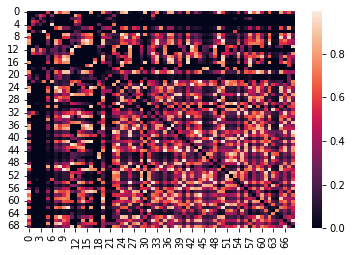

In [105]:
sns.heatmap(ar_sim)

We take a user with a decent amount of similarities

In [115]:
user_ids = [g[0] for g in gb_users]

index = pd.MultiIndex.from_tuples(user_ids, names=["user_id", "year"])
df_sim = pd.DataFrame(columns=index, index=index, data=ar_sim)
df_sim.index.set_names(['user_id', 'year'])
df_filter = pd.concat([g[1] for g in gb_users])

user_id = user_ids[24]
print("User ID / Year ", user_id)

User ID / Year  (6914714, 2021)


In [116]:
user_df = df_filter.loc[user_id]
user_df.head()

beatmap_id     score  score_transformed
user_id year                                         
6914714 2021      193131  0.912525           0.352300
        2021      204360  0.893687           0.310060
        2021      217670  0.924668           0.384254
        2021      220960  0.850516           0.229011
        2021      223266  0.956780           0.492710

Let's take a score here with a good amount of shared player plays

In [123]:
user_score = user_df.iloc[50]
user_score

beatmap_id           364220.000000
score                     0.986025
score_transformed         0.676924
Name: (6914714, 2021), dtype: float64

We have 2 scores, 1 untransformed, one transformed.
We'll predict the transformed score, then inverse transform it to see its error!

The next step is to get all scores from the same beatmap from other players

In [124]:
df_filter[df_filter['beatmap_id'] == user_df.iloc[50]['beatmap_id']]

,,beatmap_id,score,score_transformed
user_id,year,,,
3632846,2017,364220,0.917853,0.366279
3752338,2018,364220,0.956803,0.492805
4463653,2018,364220,0.899196,0.321735
4725379,2020,364220,0.935639,0.416318
5818319,2017,364220,0.733834,0.097166
6914714,2021,364220,0.986025,0.676924
7418493,2020,364220,0.935694,0.416494
8029883,2017,364220,0.937234,0.421049
8222416,2020,364220,0.983696,0.653673


In [125]:
df_score_sim = df_filter[df_filter['beatmap_id'] == user_score['beatmap_id']].merge(
    df_sim[user_id].rename('similarity'),
    left_index=True, right_index=True
).sort_values(by='similarity', ascending=False)
df_score_sim.head()

,,beatmap_id,score,score_transformed,similarity
user_id,year,,,,
7418493,2020,364220,0.935694,0.416494,0.908606
12703319,2020,364220,0.988108,0.700656,0.884981
8370443,2019,364220,0.974145,0.581285,0.825707
8454236,2020,364220,0.984381,0.660291,0.817643
13656264,2021,364220,0.976996,0.600675,0.790649


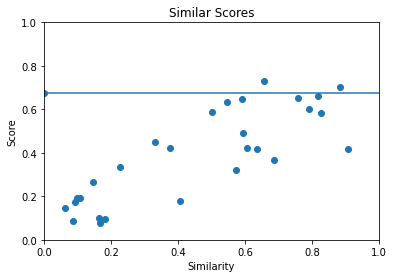

In [127]:
import matplotlib.pyplot as plt
plt.scatter(df_score_sim['similarity'], df_score_sim['score_transformed'])
plt.xlabel("Similarity")
plt.ylabel("Score")
plt.xlim(0, 1)
plt.ylim(0, 1)
_ = plt.title("Similar Scores")
_ = plt.axhline(user_score['score_transformed'])

Interestingly, we see another trend, players similar tend to have higher transformed scores, this is consistent with our idea!

However, it's not very accurate, but the idea is there!

Let's take the weighted average, then compute the error of it

In [148]:
pred = np.average(df_score_sim['score_transformed'], weights=df_score_sim['similarity'] ** 3)
actual = user_score['score_transformed']
error = (qt.inverse_transform([[pred]]) - qt.inverse_transform([[actual]])) * 1e6
print("The actual error is:", error[0][0])

The actual error is: -16640.55103181894


This implies that our prediction is just 16K below the actual result!
This is not definitive, however, it's a great start to our predictions.